In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import json
from pathlib import Path
import pandas as pd
import numpy as np
import random as rnd
import logging
from dotenv import find_dotenv, load_dotenv
import dotenv
import requests
from urllib.parse import urljoin
import subprocess
# from unidecode import unidecode
import nltk
import seaborn as sns

import dedupe

import backtester
import utils

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 60)
pd.set_option('precision', 2)
pd.set_option('max_colwidth',80)
pd.set_option('display.width', 160)

INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/Grammar.txt
INFO:root:Generating grammar tables from /usr/lib/python3.6/lib2to3/PatternGrammar.txt


In [2]:
def transform_series_to_percent(ser, precision="%.2f"):
    """prints a Series of float values nicely as percent

    Args:
        ser: Series of float values
    Returns:
        Series of strings of e.g. "12 %"
    Raises:
        none
    """
    return ser.map(lambda x: (precision+" %%") % x)

def human_readable_number(num):
    if num > 1e9:
        return "%.2f bn" % (num/1e9)
    if num > 1e6:
        return "%.2f m" % (num/1e6)
    if num > 1e4:
        return "%.2f k" % (num/1e3)
    if abs(num) <= 1.0:
        return "%.0f %%" % (100.0*num)
    return str(num)

def prettyprint( val ):
    if type(val)==pd.Series:
        return val.apply(prettyprint)
    else:
#         if pl.is_numlike(val):
        return human_readable_number(val)
#         else:
#             return val

#  used for e.g.: dataframe.groupby('key').agg({'col1':list_values_counts,'col2':list_unique_values,'col3':count_unique_values})
def list_values_counts(ser):
    vc = ser.value_counts()#[:max_values]
    vc /= vc.sum()
#     vc = filter_cumulated_values_upto_value(vc, 0.8, minentries=3)
    return ", ".join([str(x)+': '+prettyprint(y) for (x,y) in zip(vc.index,vc.values)])

def list_unique_values(ser):
    ser = ser.unique()
    return str(len(ser)) + ":" + ", ".join([str(x) for x in ser])

def count_unique_values(ser):
    return len(ser.unique())

def filter_cumulated_values_upto_value(series, neededsum, minentries=3, maxentries=10):
    series = series.sort_values()
    entriesThatSumUptoValue = np.where(series<neededsum)[0]
    if len(entriesThatSumUptoValue)==0:
        return series[:1]
    else:
        if len(series)>=minentries:
            return series[:min(entriesThatSumUptoValue[-1]+2, maxentries)]
        else:
            return series
        
def count_nans(df):
    f = lambda col: sum(df[col].isna())/float(len(df))
    return pd.Series(dict([(c,f(c)) for c in df.columns])).sort_index()
def check_column_type(ser):
    return ser.apply(type).unique()

def count_nan(ser):
    return human_readable_number(sum(ser.isna()/float(len(ser))))
def count_non_nan(ser):
    return human_readable_number(1-sum(ser.isna()/float(len(ser))))
def summaries_values(ser):
    stats = ser.value_counts(normalize=True, dropna=False)
#     stats = np.cumsum(ser.value_counts(normalize=True, dropna=False))
#     filtered_values = filter_cumulated_values_upto_value(stats, .8, maxentries=2)
    return ", ".join([str(x)+': '+prettyprint(y) for (x,y) in zip(stats.index, stats.values)])

def stats(df):
    stat_functions = [count_non_nan, count_unique_values, summaries_values]
    stat_names = ['Values set', '# Unique values', 'Most common values']
    
    stats = df.agg({x:stat_functions for x in df.columns})
    stats.index = pd.Index(stat_names)
    most_set_columns_names = stats.loc['Values set'].str.replace(' %','').astype(float).sort_values(ascending=False)
    return stats[most_set_columns_names.index]

In [3]:
load_dotenv(find_dotenv())

True

In [45]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/datascientist/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [8]:
[x for x in (Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export').glob("*/*.csv")]

[PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS1/TopNKreditorDebitorsMonthly.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS1/TopNKreditorDebitors.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS11/TopNKreditorDebitorsMonthly.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS11/TopNKreditorDebitors.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS9/TopNKreditorDebitorsMonthly.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS9/TopNKreditorDebitors.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS7/TopNKreditorDebitorsMonthly.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS7/TopNKreditorDebitors.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS14/TopNKreditorDebitorsMonthly.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS14/TopNKreditorDebitors.csv'),
 PosixPath('/home/datascientist/host/data/raw/WTC-Export/DS12/TopNKredi

### Load the WTC Data

In [4]:
path = Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export'
data = pd.DataFrame()
for file in path.glob("*/TopNKreditorDebitorsMonthly.csv"):
    df = pd.read_csv(file, sep=';')
    df['File'] = file.parts[-2]
    data = data.append(df)
data.dropna(how='all', axis='columns', inplace=True)
# data.fillna('', inplace=True)

In [5]:
stats(data)

,File,Date,Kreditor,Average Payment Frequency,All Average,Amount,Type,Kreditorname,Geschaeftspartner_Typ,Adresstyp,BLZ_1,Ort,Adressart,PLZ,Strasse,Bankkontonr_1,EU_Land,EU_UStID,LaenderKZ_1,Bankbezeichnung_1,BIC_1,IBAN_1,Bankv1_Gueltig_von,Steuernummer,Name,Postfach,Name_Nachname,Bankkontonr_2,BLZ_2,Bankbezeichnung_2,BIC_2,IBAN_2,Vorname,LaenderKZ_2,BIC_5,IBAN_5,LaenderKZ_5,Bankkontonr_5,Bankbezeichnung_5,BLZ_5,Bankv4_Gueltig_bis,Bankv3_Gueltig_bis,Bankv4_Gueltig_von,BIC_4,IBAN_4,LaenderKZ_4,Bankkontonr_4,Bankbezeichnung_4,BLZ_4,Bankv3_Gueltig_von,Bankv2_Gueltig_von,BIC_3,IBAN_3,LaenderKZ_3,Bankkontonr_3,Bankbezeichnung_3,BLZ_3,Bankv2_Gueltig_bis,Bankv1_Gueltig_bis
Values set,100 %,100 %,100 %,100 %,100 %,100 %,100 %,100 %,100 %,70 %,48 %,44 %,44 %,42 %,41 %,34 %,26 %,26 %,23 %,22 %,22 %,21 %,14 %,9 %,3 %,2 %,1 %,1 %,1 %,1 %,1 %,1 %,1 %,1 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %
# Unique values,29,63,7930,679,356,16135,2,9985,2,4,1051,2003,4,2668,3824,3408,25,2431,35,807,827,1963,11,963,219,205,109,68,61,60,55,70,84,4,2,2,2,2,2,2,2,2,5,9,9,3,10,8,8,5,12,13,15,3,15,13,13,2,3
Most common values,"ds13a.out_2018-07-31: 10 %, Datensatz Nr 9 (joimax 1240).out_2018-04-30: 9 %...","2018-03-28: 4 %, 2018-04-28: 4 %, 2018-02-28: 4 %, 2018-05-28: 3 %, 2017-12-...","71009: 0 %, 70002: 0 %, 70103: 0 %, 71905: 0 %, 70101: 0 %, 70000: 0 %, 7071...","42.0: 98 %, 0.0: 0 %, 8.0: 0 %, 14.0: 0 %, 13.0: 0 %, 11.0: 0 %, 12.0: 0 %, ...","42.0: 36 %, 41.987265009096426: 1 %, 41.99409033347405: 1 %, 41.833676975945...","0.0: 83 %, 357.0: 0 %, 1000.0: 0 %, 595.0: 0 %, 150.0: 0 %, 1309.0: 0 %, 50....","K: 71 %, D: 29 %","Unbenannter Kreditor: 0 %, Unbenannter Debitor: 0 %, Telekom Deutschland Gmb...","K: 71 %, D: 29 %","2.0: 67 %, nan: 30 %, 0.0: 2 %, 1.0: 0 %","nan: 52 %, 0.0: 12 %, 48050161.0: 1 %, 20050550.0: 1 %, 70020270.0: 1 %, 600...","nan: 56 %, München: 1 %, Berlin: 1 %, Hamburg: 1 %, Düsseldorf: 1 %, Karlsru...","nan: 56 %, STR: 42 %, PF: 2 %, GK: 0 %","nan: 58 %, 14712: 0 %, 46286: 0 %, 14727: 0 %, 98617: 0 %, 76227: 0 %, 60329...","nan: 59 %, Mainzer Landstr. 33a: 0 %, An der Salzbrücke: 0 %, Mörikeweg 1: 0...","nan: 66 %, 659705915: 0 %, 1120700: 0 %, 45014701: 0 %, 4989160540.0: 0 %, 1...","nan: 74 %, DE: 20 %, GB: 2 %, AT: 1 %, FR: 1 %, NL: 1 %, BE: 0 %, PL: 0 %, E...","nan: 74 %, 811228366: 0 %, 813422349: 0 %, U45987106: 0 %, 122265872: 0 %, 1...","nan: 77 %, DE: 20 %, FR: 0 %, AT: 0 %, GB: 0 %, NL: 0 %, CH: 0 %, IT: 0 %, I...","nan: 78 %, UniCredit Bank-HypoVereinbk: 1 %, Commerzbank München: 0 %, Volks...","nan: 78 %, COBADEFFXXX: 1 %, PBNKDEFFXXX: 1 %, HYVEDEMMXXX: 0 %, GENODEF1RN1...","nan: 79 %, DE49203205004989160540: 0 %, DE33300501100045014701: 0 %, DE91700...","nan: 86 %, 2017-01-01: 4 %, 2015-01-01: 3 %, 2013-01-01: 2 %, 2013-10-01: 2 ...","nan: 91 %, 0: 1 %, A08818254: 0 %, 31357130257: 0 %, 520557771510: 0 %, 205/...","nan: 97 %, 0,00: 1 %, Bareinzahlung : 0 %, 45778,99: 0 %, 21773,16: 0 %, 112...","nan: 98 %, 100551: 0 %, 100534.0: 0 %, 10 02 64: 0 %, PB7720: 0 %, 13 62: 0 ...","nan: 99 %, 31082015.0: 0 %, 31072015.0: 0 %, 18082015.0: 0 %, 30062015.0: 0 ...","nan: 99 %, 39184609.0: 0 %, 3284400.0: 0 %, 391027356.0: 0 %, 1360152.0: 0 %...","nan: 99 %, 70250150.0: 0 %, 50010060.0: 0 %, 16050000.0: 0 %, 34060094.0: 0 ...","nan: 99 %, Postbank Frankfurt Main: 0 %, Kr Spk München Starnbg Ebbg: 0 %, U...","nan: 99 %, COBADEFFXXX: 0 %, PBNKDEFFXXX: 0 %, BYLADEM1KMS: 0 %, WELADED1PMB...","nan: 99 %, DE26500100600039184609: 0 %, DE26100205000003284400: 0 %, AT52150...","nan: 99 %, 31082015.0: 0 %, 31072015.0: 0 %, 30062015.0: 0 %, 15072015.0: 0 ...","nan: 99 %, DE: 1 %, AT: 0 %, FI: 0 %","nan: 100 %, COBADEFFXXX: 0 %","nan: 100 %, DE36700400410152178000: 0 %","nan: 100 %, DE: 0 %","nan: 100 %, 152178000.0: 0 %","nan: 100 %, Commerzbank München: 0 %","nan: 100 %, 70040041.0: 0 %","nan: 100 %, 2016-09-30: 0 %","nan: 100 %, 2016-09-30: 0 %","nan: 100 %, 2013-10-01: 0 %, 2011-

In [40]:
text_of_all_names = "".join(data.Kreditorname.values)

In [51]:
# txt = unidecode(text_of_all_names.lower())
text_of_all_names = " ".join(df.Kreditorname.values)
txt = unidecode(text_of_all_names)

tokens = pd.Series(nltk.word_tokenize(txt))
# print(len(tokens.value_counts()))
tokens.value_counts()
# wt = tokens.value_counts()[:49]

# # tokenizer = nltk.data.load('tokenizers/punkt/german.pickle')
# # tokens = pd.Series(tokenizer.tokenize(txt))
# # print(len(tokens.value_counts()))
# # # pt = tokens.value_counts()[:50]

tokenizer = nltk.tokenize.WordPunctTokenizer()
tokens = pd.Series(tokenizer.tokenize(txt))
tokens.value_counts()
# print(len(tokens.value_counts()))
# wpt = tokens.value_counts()[:49]

# tokens = pd.DataFrame({'word_tokenizer':wt.index.values, 
# #                        'punkt_tokenizer':pt.index.values,
#                        'wordpunkt_tokenizer':wpt.index.values})
# del txt, pt, wt, wpt
# tokens

GmbH               7
.                  2
Diverse            2
-                  2
/                  1
EBV                1
Agrartechnik       1
Radio              1
optical            1
Wind               1
Digital            1
LINE               1
Munchen            1
Products           1
Diethard           1
MED                1
Ziehm              1
HY                 1
Inc                1
Co                 1
fritec             1
ARROW              1
Bayern             1
Power              1
S                  1
VERMES             1
Buro               1
Abacus             1
Trade              1
Elektronik         1
Schukat            1
KOPPEL             1
Central            1
Imaging            1
KG                 1
TTI                1
SIEMENS            1
+                  1
Components         1
Avnet              1
GMBH               1
Energy             1
AKO                1
Europe             1
BAIER              1
BBH                1
Electronic         1
,            

In [89]:
legal_forms = ['ag','gmbh','kg', 'gbr', 'mb', 'ev', 'e.v.', 'ltd', 'ug', 'llc', 'ltd']

In [81]:
def contains_legal_form(txt):
    return any([txt.lower().find(lf)!=-1 for lf in legal_forms])

In [90]:
data[~data.Kreditorname.apply(contains_legal_form)].Kreditorname.unique()

array(['Watt Deutschland', 'Thüringer Kühlhäuser Grimmenthal',
       'KWA Kommunaler Wasser-u. Abwasserzweckve', 'DIVERSE',
       'KVT Kräuterverarbeitung Ritschenhausen', 'BeGoTrans',
       'Kellner und Luther - Obermaßfeld', 'Udo Klein - Obermaßfeld',
       'Thüringer Energie', 'Syscomp ', 'Fliesenprofi',
       'KWA Meininger Umland', 'Salensa', 'Jörg Schuster',
       'Ullrich  & Naumann', 'Astaxa', 'M',
       'Malerfachbetrieb Peter Hellmann', 'SCORPION-(PL)', 'Diverse',
       'Bärnreuther Georg Schmiedemeister, Römhild',
       'Unbenannter Debitor', 'TEN Thüringer Energienetze',
       'Goldgas- nicht bebuchen!!!!!', 'Syscomp Labor - nicht bebuchen',
       'HGS Fliesen - Schrott', 'Engelbert Ruck',
       'Fliesen Profi Ritschenhausen', 'Recyclinghof KOOB',
       'Helvetia Versicherung', 'Bender - Walldorf', 'Fasold Hotel',
       'Stadtwerke Meiningen', 'UTEX', 'Lindig Gartenbau',
       'Kammlott, Gärtnereibedarf', 'Heil Autohaus',
       'EuroNorm Gesellschaft für Qua

In [153]:
data.Name_Nachname.astype(str).unique()

array(['30062015.0', 'nan', '31072015.0', '18082015.0', '6072015.0',
       '15072014.0', '29082015.0', '25082015.0', '28082015.0',
       '2032015.0', '31082015.0', '21072015.0', '7042015.0', '25062015.0',
       '31122014.0', '12062013.0', '25072011.0', '4082015.0',
       '27072015.0', '8072015.0', '13042015.0', '12082015.0',
       '21082015.0', '30082013.0', '16032015.0', '11092014.0',
       'Klingberg', 'Dr. med. Nikolaus Vollmann'], dtype=object)

In [151]:
data[['Kreditorname','Name_Nachname','Vorname','Name','Strasse','PLZ','Ort']]

,Kreditorname,Name_Nachname,Vorname,Name,Strasse,PLZ,Ort
0,goldgas GmbH,3e+07,3e+07,"0,00",Südwestpark 63,90499,Nürnberg
1,Watt Deutschland,NaN,NaN,NaN,Lyoner Str. 44-48,60528,Frankfurt/Main
2,Thüringer Kühlhäuser Grimmenthal,3.1e+07,3.1e+07,"0,00",NaN,NaN,150668
3,KWA Kommunaler Wasser-u. Abwasserzweckve,1.8e+07,1.5e+07,"436,49",Marktwasserweg 10,98617,Meiningen
4,DIVERSE,6.1e+06,6.1e+06,"0,00",NaN,NaN,150557
5,KVT Kräuterverarbeitung Ritschenhausen,1.5e+07,5.1e+06,"4949,14",NaN,NaN,Rückzahlung DZ
6,BeGoTrans,2.9e+07,2.9e+07,"0,00",NaN,NaN,150734
7,Bühler GmbH,NaN,NaN,NaN,NaN,NaN,NaN
8,Kellner und Luther - Obermaßfeld,2.5e+07,2.5e+07,"0,00",NaN,NaN,150720
9,Udo Klein - Obermaßfeld,2.8e+07,2.8e+07,"0,00",NaN,NaN,150732


In [149]:
data[['Strasse','PLZ','Ort']].dropna(axis=0, how='all')

,Strasse,PLZ,Ort
0,Südwestpark 63,90499,Nürnberg
1,Lyoner Str. 44-48,60528,Frankfurt/Main
2,NaN,NaN,150668
3,Marktwasserweg 10,98617,Meiningen
4,NaN,NaN,150557
5,NaN,NaN,Rückzahlung DZ
6,NaN,NaN,150734
8,NaN,NaN,150720
9,NaN,NaN,150732
10,An der Salzbrücke,98617,RZ DZ Miete


In [139]:
data.Kreditor.sort_values().astype(str).apply(lambda x:x[:-3]).astype(int).unique()

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  23,  25,
        26,  27,  30,  31,  32,  36,  38,  42,  43,  44,  45,  46,  48,
        49,  50,  51,  52,  58,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  86,  87,  88,  89,  91,  92,
        94,  95,  96,  97, 211, 213, 214, 215, 216, 217, 218, 219, 699,
       700, 701, 702, 704, 705, 707, 708, 711, 721, 804, 805, 807, 808,
       809, 810, 811, 812, 813, 814, 815, 819, 902, 904, 912, 915, 918])

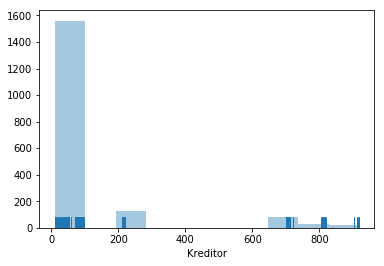

In [134]:
sns.distplot(data.Kreditor.astype(str).apply(lambda x:x[:-3]).astype(int), bins=10, kde=False, rug=True);

## Report for Jan

In [59]:
data.columns

Index(['Kreditorname', 'Kreditor', 'Average Payment Frequency', 'All Average', 'Amount', 'Type', 'Date', 'Name_Nachname', 'Vorname', 'Name', 'Adresstyp',
       'EU_Land', 'EU_UStID', 'Adressart', 'Strasse', 'Postfach', 'PLZ', 'Ort', 'BLZ_1', 'Bankbezeichnung_1', 'Bankkontonr_1', 'LaenderKZ_1', 'IBAN_1',
       'BIC_1', 'Bankv1_Gueltig_von', 'BLZ_2', 'Bankbezeichnung_2', 'Bankkontonr_2', 'LaenderKZ_2', 'IBAN_2', 'BIC_2', 'Bankv2_Gueltig_von',
       'Geschaeftspartner_Typ', 'Steuernummer', 'File'],
      dtype='object')

In [9]:
path = Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export'
data = pd.DataFrame()
for file in path.glob("DS*/TopNKreditorDebitorsMonthly.csv"):
    df = pd.read_csv(file, sep=';', dtype={'Name_Nachname':str, 'Vorname':str, 'Name':str})
    df['Quelle'] = file.parts[-2]
    data = data.append(df)
data.dropna(how='all', axis='columns', inplace=True)
df = data[['Kreditorname', 'Kreditor', 'Name_Nachname', 'Vorname', 'Name', 'Strasse', 'Postfach', 'PLZ', 'Ort', 'Quelle']].copy()
df.fillna('', inplace=True)

def is_a_number(x):
    if len(x) == 0:
        return False
    try:        
        tmp = float(x)
        return True
    except ValueError:
        return False

df.loc[df.Kreditorname.str.lower().str.contains('diverse'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Axima'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Unbenannter'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('nicht'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Bareinzahlung'), 'Auffällig'] = 'x'
df.loc[df.Name_Nachname.apply(is_a_number), 'Auffällig'] = 'x'
df.loc[df.Name.apply(is_a_number), 'Auffällig'] = 'x'
df.loc[df.Vorname.apply(is_a_number), 'Auffällig'] = 'x'

df.drop_duplicates(inplace=True)
df.fillna('', inplace=True)
df.to_pickle(Path(os.environ['DATA_PATH']) / 'processed/WCT_export.pkl')
df.to_excel(Path(os.environ['DATA_PATH']) / 'processed/WCT_Export.xlsx', index=False)

sum(df['Auffällig']=='x') / len(df)

0.08492201039861352

In [8]:
df.Quelle.unique()

array(['DS13c.out_2016-09-30', 'DS1', 'DS11', 'DS9',
       'DS13d.out_2018-07-28', 'DS7', 'DS13b.out_2018-09-30', 'DS14',
       'DS12', 'DS3'], dtype=object)

In [114]:
df[df['Auffällig']=='x']

,Kreditorname,Kreditor,Name_Nachname,Vorname,Name,Strasse,Postfach,PLZ,Ort,Quelle,Auffällig
0,goldgas GmbH,70628,30062015,30062015,"0,00",Südwestpark 63,,90499,Nürnberg,DS1,x
1,Watt Deutschland,72204,,,,Lyoner Str. 44-48,,60528,Frankfurt/Main,DS1,x
2,Thüringer Kühlhäuser Grimmenthal,71916,31072015,31072015,"0,00",,,,150668,DS1,x
3,KWA Kommunaler Wasser-u. Abwasserzweckve,71017,18082015,15072015,"436,49",Marktwasserweg 10,,98617,Meiningen,DS1,x
4,DIVERSE,79999,06072015,06072015,"0,00",,,,150557,DS1,x
5,KVT Kräuterverarbeitung Ritschenhausen,71001,15072014,05062014,"4949,14",,,,Rückzahlung DZ,DS1,x
6,BeGoTrans,70184,29082015,29082015,"0,00",,,,150734,DS1,x
7,Bühler GmbH,70180,,,,,,,,DS1,x
8,Kellner und Luther - Obermaßfeld,71004,25082015,25082015,"0,00",,,,150720,DS1,x
9,Udo Klein - Obermaßfeld,72003,28082015,28082015,"0,00",,,,150732,DS1,x


In [57]:
df[df.Kreditorname.str.lower().str.contains('debitoren')]

,Kreditorname,Kreditor,Name_Nachname,Vorname,Name,Strasse,Postfach,PLZ,Ort,Quelle,Auffällig


In [87]:
c = pd.read_csv( Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export' / 'DS11' / 'TopNKreditorDebitorsMonthly.csv', sep=';')

In [88]:
c[:5]

,Kreditorname,Kreditor,Average Payment Frequency,All Average,Amount,Type,Date,Name_Nachname,Vorname,Name,Adresstyp,EU_Land,EU_UStID,Adressart,Strasse,Postfach,PLZ,Ort,BLZ_1,Bankbezeichnung_1,Bankkontonr_1,LaenderKZ_1,IBAN_1,BIC_1,Bankv1_Gueltig_von,Bankv1_Gueltig_bis,BLZ_2,Bankbezeichnung_2,Bankkontonr_2,LaenderKZ_2,IBAN_2,BIC_2,Bankv2_Gueltig_von,Bankv2_Gueltig_bis,BLZ_3,Bankbezeichnung_3,Bankkontonr_3,LaenderKZ_3,IBAN_3,BIC_3,Bankv3_Gueltig_von,Bankv3_Gueltig_bis,BLZ_4,Bankbezeichnung_4,Bankkontonr_4,LaenderKZ_4,IBAN_4,BIC_4,Bankv4_Gueltig_von,Bankv4_Gueltig_bis,BLZ_5,Bankbezeichnung_5,Bankkontonr_5,LaenderKZ_5,IBAN_5,BIC_5,Bankv5_Gueltig_von,Bankv5_Gueltig_bis,Geschaeftspartner_Typ,Steuernummer
0,RSB Retail+Service Bank GmbH,71710,42.00,37.29,310582.08,K,2017-06-30,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN
1,Cecil GmbH,70202,6.60,37.29,224670.22,K,2017-06-30,NaN,NaN,NaN,2,DE,8.14e+08,STR,Neue Wiesen 1,NaN,30900.0,Wedemark - Elze,2.01e+07,Dresdner Bank Hamburg,9.06e+08,DE,NaN,NaN,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN
2,Closed GmbH,70212,7.75,37.29,93063.03,K,2017-06-30,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN
3,Street One GmbH,71818,6.38,37.29,74750.01,K,2017-06-30,NaN,NaN,NaN,2,DE,8.14e+08,STR,Imkerstrasse 4,NaN,30916.0,Isernhagen-Kirchhorst,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN
4,Opus Handels GmbH,71406,11.07,37.29,23847.38,K,2017-06-30,NaN,NaN,NaN,2,DE,2.11e+08,STR,Marienfelder Strasse 50,NaN,33442.0,Herzebrock,4.80e+07,Bankhaus Lampe Bielefeld,4.19e+05,DE,DE18478535200001018472,LAMPDEDDXXX,2013-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN


## 2018-10-15 New Exports

In [6]:
path = Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export'
all_exports = pd.DataFrame()
for file in path.glob("Datensatz*/TopNKreditorDebitorsMonthly.csv"):
    df = pd.read_csv(file, sep=';')
    df['File'] = file.parts[-2]
    all_exports = all_exports.append(df)
all_exports.dropna(how='all', axis='columns', inplace=True)
# data.fillna('', inplace=True)

In [68]:
stats(all_exports)

,File,Date,Kreditor,Average Payment Frequency,All Average,Amount,Type,Kreditorname,Geschaeftspartner_Typ,Adresstyp,Ort,Adressart,PLZ,Strasse,BLZ_1,Bankkontonr_1,LaenderKZ_1,Bankbezeichnung_1,BIC_1,IBAN_1,EU_UStID,EU_Land,Bankv1_Gueltig_von,Steuernummer,Name,Postfach,Name_Nachname,BLZ_2,Vorname,Bankbezeichnung_2,LaenderKZ_2,IBAN_2,BIC_2,Bankkontonr_2,Bankv1_Gueltig_bis,Bankbezeichnung_4,BIC_4,BIC_5,IBAN_5,LaenderKZ_5,Bankkontonr_5,Bankbezeichnung_5,IBAN_4,LaenderKZ_4,Bankkontonr_4,Bankv3_Gueltig_von,BLZ_4,BIC_3,IBAN_3,LaenderKZ_3,Bankkontonr_3,Bankbezeichnung_3,BLZ_3,Bankv2_Gueltig_von,Bankv4_Gueltig_von,BLZ_5
Values set,100 %,100 %,100 %,100 %,100 %,100 %,100 %,100 %,100 %,85 %,50 %,50 %,47 %,46 %,37 %,33 %,29 %,29 %,29 %,27 %,24 %,24 %,17 %,5 %,4 %,3 %,2 %,1 %,1 %,1 %,1 %,1 %,1 %,1 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %,0 %
# Unique values,14,53,5569,627,259,12915,2,6825,2,4,1829,4,2348,3189,828,2330,33,781,796,1897,1678,23,11,330,219,180,109,55,84,54,4,62,49,60,2,8,9,2,2,2,2,2,9,3,9,4,8,10,13,3,13,11,11,12,5,2
Most common values,"Datensatz Nr 9 (joimax 1240).out_2018-04-30: 13 %, Datensatz Nr 5 SKR03 (Imp...","2017-08-28: 4 %, 2017-02-28: 4 %, 2017-06-28: 4 %, 2017-05-28: 4 %, 2017-04-...","70103: 0 %, 70001: 0 %, 71903: 0 %, 70002: 0 %, 71202: 0 %, 70408: 0 %, 7021...","42.0: 98 %, 0.0: 0 %, 8.0: 0 %, 2.0: 0 %, 12.0: 0 %, 13.0: 0 %, 11.0: 0 %, 5...","42.0: 23 %, 41.940620155038765: 1 %, 41.91479069767441: 1 %, 41.931418918918...","0.0: 82 %, 357.0: 0 %, 1309.0: 0 %, 142.8: 0 %, 595.0: 0 %, 1190.0: 0 %, 100...","K: 72 %, D: 28 %","Unbenannter Kreditor: 0 %, Unbenannter Debitor: 0 %, Telekom Deutschland Gmb...","K: 72 %, D: 28 %","2.0: 82 %, nan: 15 %, 0.0: 3 %, 1.0: 1 %","nan: 50 %, München: 1 %, Berlin: 1 %, Karlsruhe: 1 %, Hamburg: 1 %, Nürnberg...","nan: 50 %, STR: 47 %, PF: 2 %, GK: 0 %","nan: 53 %, 14712: 1 %, 14727: 0 %, 76227: 0 %, 98617: 0 %, 66111: 0 %, 42551...","nan: 54 %, An der Salzbrücke: 0 %, Bublitzer Str. 34: 0 %, Ludwig-Erhard-Str...","nan: 63 %, 0.0: 3 %, 20050550.0: 1 %, 70020270.0: 1 %, 20040000.0: 0 %, 1609...","nan: 67 %, 45014701: 0 %, 820054500.0: 0 %, 696633000: 0 %, 764003000.0: 0 %...","nan: 71 %, DE: 26 %, FR: 1 %, AT: 1 %, GB: 0 %, NL: 0 %, CH: 0 %, IT: 0 %, I...","nan: 71 %, UniCredit Bank-HypoVereinbk: 1 %, Commerzbank München: 1 %, Volks...","nan: 71 %, COBADEFFXXX: 2 %, PBNKDEFFXXX: 1 %, HYVEDEMMXXX: 1 %, GENODEF1RN1...","nan: 73 %, DE33300501100045014701: 0 %, DE32795800990156120001: 0 %, DE41763...","nan: 76 %, 813422349: 0 %, 811228366: 0 %, 122265872: 0 %, U45987106: 0 %, 1...","nan: 76 %, DE: 15 %, GB: 3 %, AT: 1 %, FR: 1 %, NL: 1 %, BE: 0 %, PL: 0 %, I...","nan: 83 %, 2017-01-01: 5 %, 2015-01-01: 4 %, 2013-01-01: 3 %, 2013-10-01: 2 ...","nan: 95 %, 0: 1 %, 045/231/28552: 0 %, 235420003526: 0 %, 046/211/09117: 0 %...","nan: 96 %, 0,00: 1 %, VersinstZ San Mat Quakenbrück: 0 %, Jürgen Kulik: 0 %,...","nan: 97 %, 100534.0: 0 %, 100551: 0 %, 13 62: 0 %, 1460: 0 %, 500260: 0 %, 6...","nan: 98 %, 31082015.0: 0 %, 31072015.0: 0 %, 18082015.0: 0 %, 16062015.0: 0 ...","nan: 99 %, 50010060.0: 0 %, 70250150.0: 0 %, 10020500.0: 0 %, 34060094.0: 0 ...","nan: 99 %, 31082015.0: 0 %, 31072015.0: 0 %, 15072015.0: 0 %, 18082015.0: 0 ...","nan: 99 %, Postbank Frankfurt Main: 0 %, Kr Spk München Starnbg Ebbg: 0 %, U...","nan: 99 %, DE: 1 %, AT: 0 %, FI: 0 %","nan: 99 %, DE26500100600039184609: 0 %, DE26100205000003284400: 0 %, DE11702...","nan: 99 %, COBADEFFXXX: 0 %, PBNKDEFFXXX: 0 %, BYLADEM1KMS: 0 %, VBRSDE33XXX...","nan: 99 %, 39184609.0: 0 %, 3284400.0: 0 %, 391027356.0: 0 %, 10021988.0: 0 ...","nan: 100 %, 2017-09-30: 0 %","nan: 100 %, Raiffeisenbank Region: 0 %, Commerzbank München: 0 %, Sparkasse ...","nan: 100 %, RLNWATWW939: 0 %, COLSDE33XXX: 0 %, COBADEFF700: 0 %, COBADEFFXX...","nan: 100 %, COBADEFFXXX: 0 %","nan: 100 %, DE36700400410152178000: 0 %","nan: 100 %, DE: 0 %","nan: 100 %, 152178000.0: 0 %","nan: 100 %, Commerzbank München: 0 %","nan: 10

In [92]:
len(all_exports.Kreditorname.unique())

6825

In [91]:
all_exports[all_exports.Kreditorname.str.contains('Schmidt')]

,Kreditorname,Kreditor,Average Payment Frequency,All Average,Amount,Type,Date,Name_Nachname,Vorname,Name,Adresstyp,EU_Land,EU_UStID,Adressart,Strasse,Postfach,PLZ,Ort,BLZ_1,Bankbezeichnung_1,Bankkontonr_1,LaenderKZ_1,IBAN_1,BIC_1,Bankv1_Gueltig_von,Bankv1_Gueltig_bis,BLZ_2,Bankbezeichnung_2,Bankkontonr_2,LaenderKZ_2,IBAN_2,BIC_2,Bankv2_Gueltig_von,BLZ_3,Bankbezeichnung_3,Bankkontonr_3,LaenderKZ_3,IBAN_3,BIC_3,Bankv3_Gueltig_von,BLZ_4,Bankbezeichnung_4,Bankkontonr_4,LaenderKZ_4,IBAN_4,BIC_4,Bankv4_Gueltig_von,BLZ_5,Bankbezeichnung_5,Bankkontonr_5,LaenderKZ_5,IBAN_5,BIC_5,Geschaeftspartner_Typ,Steuernummer,File
167,Schmidt + Bartl GmbH,77154,42.0,41.88,0.0,K,2017-05-30,NaN,NaN,Schmidt + Bartl GmbH,0.0,NaN,NaN,STR,Auf Herdenen 30,NaN,78052,Villingen-Schwenningen,6.44e+07,Volksbank Donau-Neckar,510365000,DE,DE59643901300510365000,GENODES1TUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
211,Schmidt & Schmidt,77168,42.0,41.88,0.0,K,2017-05-30,NaN,NaN,NaN,2.0,DE,143701821,STR,Weberstraße 6,NaN,76133,Karlsruhe,6.01e+07,LBBW/BW-Bank Stuttgart,7495510713,DE,DE93600501017495510713,SOLADEST600,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
416,Hotel Schmidt-Mönnikes,72622,42.0,41.88,0.0,K,2017-05-30,NaN,NaN,NaN,2.0,NaN,NaN,STR,Drusenbergstr. 164,NaN,44789,Bochum,4.31e+07,Sparkasse Bochum,39405576,DE,DE48430500010039405576,WELADED1BOC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
839,Rolandas Janusas u. Helmut Schmidt Gbr,16679,42.0,41.76,0.0,D,2017-05-30,NaN,NaN,NaN,2.0,NaN,NaN,STR,Merzenicher Str. 33,NaN,52351,Düren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1055,Schmidt + Bartl GmbH,77154,42.0,41.76,0.0,K,2017-06-30,NaN,NaN,Schmidt + Bartl GmbH,0.0,NaN,NaN,STR,Auf Herdenen 30,NaN,78052,Villingen-Schwenningen,6.44e+07,Volksbank Donau-Neckar,510365000,DE,DE59643901300510365000,GENODES1TUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1100,Schmidt & Schmidt,77168,42.0,41.76,0.0,K,2017-06-30,NaN,NaN,NaN,2.0,DE,143701821,STR,Weberstraße 6,NaN,76133,Karlsruhe,6.01e+07,LBBW/BW-Bank Stuttgart,7495510713,DE,DE93600501017495510713,SOLADEST600,2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1303,Hotel Schmidt-Mönnikes,72622,42.0,41.76,0.0,K,2017-06-30,NaN,NaN,NaN,2.0,NaN,NaN,STR,Drusenbergstr. 164,NaN,44789,Bochum,4.31e+07,Sparkasse Bochum,39405576,DE,DE48430500010039405576,WELADED1BOC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1723,Rolandas Janusas u. Helmut Schmidt Gbr,16679,42.0,41.64,0.0,D,2017-06-30,NaN,NaN,NaN,2.0,NaN,NaN,STR,Merzenicher Str. 33,NaN,52351,Düren,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,D,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1931,Schmidt + Bartl GmbH,77154,42.0,41.80,0.0,K,2017-07-30,NaN,NaN,Schmidt + Bartl GmbH,0.0,NaN,NaN,STR,Auf Herdenen 30,NaN,78052,Villingen-Schwenningen,6.44e+07,Volksbank Donau-Neckar,510365000,DE,DE59643901300510365000,GENODES1TUT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 9 (joimax 1240).out_2018-04-30
1975,Schmidt & Schmidt,77168,42.0,41.

In [7]:
ds7e = all_exports[all_exports.File.str.contains('7e')]
ds7e.File.unique()

array(['Datensatz Nr 7e (Dickersbach 22164).out_2017-12-31'], dtype=object)

In [14]:
len(ds7e)

8658

In [15]:
len(ds7e.Kreditor.unique())

666

In [21]:
df = ds7e[ds7e.Kreditorname.str.contains('CHV')]

In [67]:
# df[['Date','Amount']].sort_values('Date')

In [8]:
ds5 = all_exports[all_exports.File.str.contains('Impac')]
ds5.File.unique()

array(['Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31'], dtype=object)

In [9]:
ds5[:5]

,Kreditorname,Kreditor,Average Payment Frequency,All Average,Amount,Type,Date,Name_Nachname,Vorname,Name,Adresstyp,EU_Land,EU_UStID,Adressart,Strasse,Postfach,PLZ,Ort,BLZ_1,Bankbezeichnung_1,Bankkontonr_1,LaenderKZ_1,IBAN_1,BIC_1,Bankv1_Gueltig_von,Bankv1_Gueltig_bis,BLZ_2,Bankbezeichnung_2,Bankkontonr_2,LaenderKZ_2,IBAN_2,BIC_2,Bankv2_Gueltig_von,BLZ_3,Bankbezeichnung_3,Bankkontonr_3,LaenderKZ_3,IBAN_3,BIC_3,Bankv3_Gueltig_von,BLZ_4,Bankbezeichnung_4,Bankkontonr_4,LaenderKZ_4,IBAN_4,BIC_4,Bankv4_Gueltig_von,BLZ_5,Bankbezeichnung_5,Bankkontonr_5,LaenderKZ_5,IBAN_5,BIC_5,Geschaeftspartner_Typ,Steuernummer,File
0,Kin-Tec Global Recruitment | nan,500284,42.0,42.0,23947.50,K,2018-01-31,NaN,NaN,NaN,NaN,GB,927520033,NaN,NaN,NaN,NaN,NaN,6.00e+05,NaN,70541906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31
1,"PATZOLD, KÖBKE & PARTNER ENG. GMBH | nan",500593,42.0,42.0,18718.70,K,2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.01e+07,NaN,1380129476,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31
2,Kin-Tec Global Ltd. W.L.L. | nan,501231,42.0,42.0,14165.35,K,2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00e+00,NaN,001-534569-001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31
3,Miscellaneous creditors | nan,500000,42.0,42.0,14101.37,K,2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.50e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31
4,dieBrue Consulting | nan,501241,42.0,42.0,10234.00,K,2018-01-31,NaN,NaN,NaN,NaN,DE,293471762,NaN,NaN,NaN,NaN,NaN,2.90e+07,NaN,184224400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31


In [10]:
ds5[ds5.Kreditorname.str.contains('EASTcom')]

,Kreditorname,Kreditor,Average Payment Frequency,All Average,Amount,Type,Date,Name_Nachname,Vorname,Name,Adresstyp,EU_Land,EU_UStID,Adressart,Strasse,Postfach,PLZ,Ort,BLZ_1,Bankbezeichnung_1,Bankkontonr_1,LaenderKZ_1,IBAN_1,BIC_1,Bankv1_Gueltig_von,Bankv1_Gueltig_bis,BLZ_2,Bankbezeichnung_2,Bankkontonr_2,LaenderKZ_2,IBAN_2,BIC_2,Bankv2_Gueltig_von,BLZ_3,Bankbezeichnung_3,Bankkontonr_3,LaenderKZ_3,IBAN_3,BIC_3,Bankv3_Gueltig_von,BLZ_4,Bankbezeichnung_4,Bankkontonr_4,LaenderKZ_4,IBAN_4,BIC_4,Bankv4_Gueltig_von,BLZ_5,Bankbezeichnung_5,Bankkontonr_5,LaenderKZ_5,IBAN_5,BIC_5,Geschaeftspartner_Typ,Steuernummer,File
7,EASTcom trading + consulting GmbH | nan,501247,42.0,42.0,4760.0,K,2018-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.01e+07,NaN,06188940,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 5 SKR03 (Impac 96534).out_2018-12-31


## 2nd Report of strange deptor entries

In [90]:
path = Path(os.environ['DATA_PATH']) / 'raw' / 'WTC-Export'
data = pd.DataFrame()
for file in path.glob("Datensatz*/TopNKreditorDebitorsMonthly.csv"):
    df = pd.read_csv(file, sep=';', dtype={'Name_Nachname':str, 'Vorname':str, 'Name':str})
    df['Quelle'] = file.parts[-2]
    data = data.append(df)
data.dropna(how='all', axis='columns', inplace=True)
df = data[['Kreditorname', 'Kreditor', 'Name_Nachname', 'Vorname', 'Name', 'Strasse', 'Postfach', 'PLZ', 'Ort', 'Quelle']].copy()
df.fillna('', inplace=True)

def is_a_number(x):
    if len(x) == 0:
        return False
    try:        
        tmp = float(x)
        return True
    except ValueError:
        return False

df.loc[df.Kreditorname.str.lower().str.contains('diverse'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Axima'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Unbenannter'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('gesperrt'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('kein'), 'Auffällig'] = 'x'
df.loc[df.Kreditorname.str.contains('Bareinzahlung'), 'Auffällig'] = 'x'
df.loc[df.Name_Nachname.apply(is_a_number), 'Auffällig'] = 'x'
df.loc[df.Name.apply(is_a_number), 'Auffällig'] = 'x'
df.loc[df.Vorname.apply(is_a_number), 'Auffällig'] = 'x'

df.drop_duplicates(inplace=True)
df.fillna('', inplace=True)
df.to_pickle(Path(os.environ['DATA_PATH']) / 'processed/WCT_export.pkl')
df.to_excel(Path(os.environ['DATA_PATH']) / 'processed/WCT_Export.xlsx', index=False)

print(f"Found {100.*sum(df['Auffällig']=='x') / len(df):.1f} % suspicious entries")
                                                    
                                                    

Found 4.0 % suspicious entries


In [1]:
df[df.Kreditorname.str.contains('kein')]

NameError: name 'df' is not defined

In [30]:
source_counts_per_kreditor = df.groupby('Kreditorname').Quelle.unique().apply(len)
len(source_counts_per_kreditor[source_counts_per_kreditor>1].sort_values(ascending=False))


116

In [17]:
for g in df.groupby('Quelle').Kreditorname.unique():
    pass

In [47]:
all_exports[all_exports.Kreditorname.str.contains('ADS Drehservice GmbH')][:10]

,Kreditorname,Kreditor,Average Payment Frequency,All Average,Amount,Type,Date,Name_Nachname,Vorname,Name,Adresstyp,EU_Land,EU_UStID,Adressart,Strasse,Postfach,PLZ,Ort,BLZ_1,Bankbezeichnung_1,Bankkontonr_1,LaenderKZ_1,IBAN_1,BIC_1,Bankv1_Gueltig_von,Bankv1_Gueltig_bis,BLZ_2,Bankbezeichnung_2,Bankkontonr_2,LaenderKZ_2,IBAN_2,BIC_2,Bankv2_Gueltig_von,BLZ_3,Bankbezeichnung_3,Bankkontonr_3,LaenderKZ_3,IBAN_3,BIC_3,Bankv3_Gueltig_von,BLZ_4,Bankbezeichnung_4,Bankkontonr_4,LaenderKZ_4,IBAN_4,BIC_4,Bankv4_Gueltig_von,BLZ_5,Bankbezeichnung_5,Bankkontonr_5,LaenderKZ_5,IBAN_5,BIC_5,Geschaeftspartner_Typ,Steuernummer,File
166,ADS Drehservice GmbH,70109,42.0,41.84,0.00,K,2017-01-31,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
441,ADS Drehservice GmbH,70109,42.0,41.42,0.00,K,2017-02-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
552,ADS Drehservice GmbH,70109,42.0,42.00,255.26,K,2017-03-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
984,ADS Drehservice GmbH,70109,42.0,41.69,0.00,K,2017-04-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
1253,ADS Drehservice GmbH,70109,42.0,41.88,0.00,K,2017-05-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
1524,ADS Drehservice GmbH,70109,42.0,41.68,0.00,K,2017-06-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
1791,ADS Drehservice GmbH,70109,42.0,41.84,0.00,K,2017-07-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
2061,ADS Drehservice GmbH,70109,42.0,41.59,0.00,K,2017-08-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
2334,ADS Drehservice GmbH,70109,42.0,41.84,0.00,K,2017-09-28,NaN,NaN,NaN,2.0,DE,193843571,STR,Ridderstraße 57,NaN,48683,Ahaus,4.02e+07,Volksbank Gronau-Ahaus,3.6e+09,DE,DE21401640243602100600,GENODEM1GRN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,K,NaN,Datensatz Nr 7d (CHV 22163).out_2017-12-31
2468,ADS Drehservice GmbH,70109,42.0,42.00,89.25,K,2017-10-28,Na

## Checking ERS results from Gerardo

In [4]:
pwd

'/home/datascientist/host/src/notebooks'

In [45]:
df = pd.read_csv('../../data/raw/2019-02-22-companies-from-dedupe.csv')
df = df[['Cluster ID', 'crmId', 'buergelId', 'name', 'email', 'phoneNumber', 'website', 'address.street', 'address.postalCode', 'address.city', 'legalForm']]

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:3044: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [16]:
df.name.str.lower().value_counts()[40:60]

räkers & partner gbr                                        6
sparkasse leipzig                                           5
sfs steuerberatungsgesellschaft mbh                         5
voss  schnitger steenken bünger partg mbb                   5
matthäi bauunternehmen gmbh & co. kg                        5
advitax steuerberatungsgesellschaft mbh                     5
sparkasse hannover                                          5
lwsg wirtschafts- und steuerberatungsgesellschaft m.b.h.    5
sparkasse bochum                                            5
sparkasse essen                                             5
u-turn management gmbh & co. kg                             5
sparkasse ingolstadt eichstätt                              5
stadtsparkasse düsseldorf                                   5
sparkasse baden-baden gaggenau                              5
orlando management ag                                       5
solvesta ag                                                 5
temke & 

In [21]:
df[df.name.str.lower().str.startswith('wimmer')]

,Cluster ID,crmId,buergelId,name,legalForm,email,phoneNumber,website,vatID,registerNumber,commercialRegister,address.street,address.postalCode,address.city,address.country
8688,12908,8921,2.69e+06,Wimmers Industrieprodukte GmbH,NaN,info@wimmers-gmbh.de,+492152518081,http://http//www.wimmers-gmbh.de,NaN,NaN,NaN,Industriering Ost 76,47906,Kempen,NaN
14781,18283,15039,4.27e+07,Wimmer Holzbau GmbH & Co. KG,NaN,holzbau-sigmund-wimmer@t-online.de,+49868498860,http://http//www.holzbau-wimmer.de,NaN,NaN,NaN,Tittmoninger Str. 33,83413,Fridolfing,NaN
15285,897,15545,1.78e+07,Wimmer GmbH,NaN,mail@wimmer-gmbh.de,+49863139840,http://http//www.wimmer-gmbh.de,NaN,NaN,NaN,Alzstr. 3,84513,Töging a. Inn,NaN
18886,21897,19172,NaN,Wimmer Wohnkollektionen e.K.,NaN,info@wimmer-wohnkollektionen.de,+498581989390,http://http//www.wimmer-wohnkollektionen.de,NaN,NaN,NaN,Frischeck 56,94065,Waldkirchen,NaN
22247,24826,22610,NaN,Wimmer GmbH & Co. Investions KG,gmbh_co_kg,m.pilger@mywimmer.com,+4949856198590,http://www.mywimmer.com/,NaN,NaN,NaN,Ringstraße 14,84347,Pfarrkirchen,NaN
31338,32632,51782,6.18e+06,Wimmer GmbH Bürstenrohstoffe,NaN,wimmer-oberkirch@t-online.de,NaN,http://http//www.wimmer-oberkirch.de,NaN,NaN,NaN,Müllen 7,77704,Oberkirch,NaN
79412,72255,110404,NaN,Wimmers & Schrahe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friedrich-Ebert-Str. 162,32760,Detmold,NaN


In [20]:
len(df)

87211

In [22]:
pwd

'/home/datascientist/host/src/notebooks'

In [46]:
dups = pd.read_csv('../../data/raw/all_the_duplicates_that_web_have_lead_54.csv')
dups = dups[['id', 'buergel_id', 'name', 'hq_email', 'hq_phone', 'website', 'hq_street', 'hq_street2', 'hq_zip_code', 'hq_city', 'legal_form']]

In [47]:
dups[:5]

,id,buergel_id,name,hq_email,hq_phone,website,hq_street,hq_street2,hq_zip_code,hq_city,legal_form
0,125095,NaN,Zürn GmbH & Co. KG,info@zuern.com,49892123960,http://www.zuern.com,Thierschstr. 11,NaN,80538,München,gmbh_co_kg
1,181926,NaN,ZukunftsEnergie Fichtelgebirge GmbH,info@z-e-f.info,4992328870,https://www.zef-buergerbeteiligung.de/,Rot-Kreuz-Str. 6,NaN,95632,Wunsiedel,gmbh
2,159066,NaN,ZukunftsEnergie Fichtelgebirge GmbH,info@z-e-f.info,4992328870,https://www.zef-buergerbeteiligung.de/,Rot-Kreuz-Str. 6,NaN,95632,Wunsiedel,gmbh
3,130091,NaN,Zorn GmbH & Co. KG,zorn@zorn-fleischwaren.de,492166953500,http://www.zorn-fleischwaren.de,Schillingstaler Weg 1,NaN,41189,Mönchengladbach,gmbh_co_kg
4,138923,NaN,Zöllner-Wiethoff GmbH,zoewie@zoewie.com,4995688490,http://www.zoewie.com,Röntgenstr. 3,NaN,96465,Neustadt bei Coburg,gmbh


In [55]:
# website different:
df[df.name.str.lower().str.startswith('zukunftse')]

,Cluster ID,crmId,buergelId,name,email,phoneNumber,website,address.street,address.postalCode,address.city,legalForm
86849,77967,118602,NaN,ZukunftsEnergie Fichtelgebirge GmbH,info@z-e-f.info,5e+09,http://www.z-e-f.info,Rot-Kreuz-Str. 6,95632,Wunsiedel,gmbh


In [37]:
# the addresses are different:
df[df.name.str.lower().str.startswith('zorn gm')]

,Cluster ID,crmId,buergelId,name,legalForm,email,phoneNumber,website,vatID,registerNumber,commercialRegister,address.street,address.postalCode,address.city,address.country
7286,11645,7514,NaN,Zorn GmbH & Co. KG,NaN,zorn@zorn-gmbh.de,+49777193330,http://http//www.zorn-fleischwaren.de,NaN,NaN,NaN,Höllstrasse 11,78333,Stockach,NaN


In [56]:
# city differ
df[df.name.str.lower().str.startswith('zöllner-w')]

,Cluster ID,crmId,buergelId,name,email,phoneNumber,website,address.street,address.postalCode,address.city,legalForm
20122,22983,20420,1.28e+06,Zöllner-Wiethoff GmbH,zoewie@zoewie.com,+4995688490,http://http//www.zoewie.com,Röntgenstr. 3,96465,Neustadt b. Coburg,NaN


In [60]:
dups[5:6]

,id,buergel_id,name,hq_email,hq_phone,website,hq_street,hq_street2,hq_zip_code,hq_city,legal_form
5,132208,NaN,Zippel AG,info@zippelag.de,49918795440,http://www.zippelag.de,Mühlweg 31,NaN,90518,Altdorf,ag


In [62]:
# city and street differ
df[df.name.str.lower().str.startswith('zippel ag')]

,Cluster ID,crmId,buergelId,name,email,phoneNumber,website,address.street,address.postalCode,address.city,legalForm
58997,1718,86078,NaN,Zippel AG,info@zippelag.de,+49918795440,http://http//www.zippelag.de,Mühlweg 31,90518,Altdorf b. Nürnberg,NaN


In [63]:
dups[6:7]

,id,buergel_id,name,hq_email,hq_phone,website,hq_street,hq_street2,hq_zip_code,hq_city,legal_form
6,139407,NaN,Zimmermann GmbH,info@spedition-zimmermann.de,49984398080,http://www.heinloth.com,Am Containerbahnhof 1,NaN,91605,Gallmersgarten,gmbh


In [66]:
# city and street differ
df[df.name.str.lower().str.startswith('zimmermann gmbh')]

,Cluster ID,crmId,buergelId,name,email,phoneNumber,website,address.street,address.postalCode,address.city,legalForm
12395,1160,12639,NaN,Zimmermann GmbH,info@zimmermann-stadtmoeblierung.de,+49271313890,http://zimmermann-stadtmoeblierung.de,Fludersbach 226,57074,Siegen,NaN
16067,19437,16332,5.85e+06,Zimmermann GmbH Druck + Verlag,info@druck-zimmermann.de,+49893218400,http://http//www.zimmermann-druck.com,Einsteinstr. 4,85716,Unterschleißheim.,NaN
24294,1160,44684,NaN,Zimmermann GmbH,info@zimmermann-neukirchen.de,NaN,http://http//www.zimmermann-neukirchen.de,Hauptschwendaer Str. 10,34626,Neukirchen,NaN
29846,31345,50279,2.12e+07,Zimmermann GmbH Tankschutz - Behälterbau,info@zimmermann-tankschutz.de,NaN,http://http//www.zimmermann-tankschutz.de,Marie-Curie-Str. 7-9,68219,Mannheim,NaN


## Examing the learned weights of a dedupe model

In [64]:
import dedupe;
import numpy as np
import pandas as pd

def model_info(model_file_path):
    with open(model_file_path, 'rb') as model_file:
        dedupe_model = dedupe.StaticGazetteer(model_file)

    odds = np.exp(dedupe_model.classifier.weights)
    rel_weights = odds/sum(odds)

    df = pd.DataFrame(index = dedupe_model.data_model.primary_fields)
    df['relative_weight'] = rel_weights
    df['odd_ratio'] = odds
    print(df)
    
model_info('latest.model')
    

INFO:dedupe.api:((SimplePredicate: (sameFiveCharStartPredicate, name), SimplePredicate: (sameThreeCharStartPredicate, name)), (SimplePredicate: (commonFourGram, address.street), SimplePredicate: (nearIntegersPredicate, address.postal_code)))


                               relative_weight  odd_ratio
(name: String)                        0.000116   0.002720
(address.street: String)              0.014392   0.337815
(legal_form: Exact)                   0.027950   0.656048
(address.postal_code: String)         0.025957   0.609273
(address.city: String)                0.000448   0.010512
(email: Exact)                        0.166939   3.918460
(website: Exact)                      0.029708   0.697321
(address.country: String)             0.617543  14.495236
(register_number: String)             0.004599   0.107947
(phone_number: Exact)                 0.093789   2.201466
(vat_id: Exact)                       0.018559   0.435628


## Speed check of indexing entries into dedupe

In [3]:
pwd

'/home/datascientist/host/src/notebooks'

In [4]:
model_filepath = list(Path.cwd().glob(f"**/{os.environ.get('DEDUPE_MODEL', 'latest.model')}"))
assert len(model_filepath) == 1, f'Dont know what file to load as dedupe model. Found more too many options: {model_filepath}.'
model_filepath = model_filepath[0]
# assert MODEL_FILEPATH.exists(), f'No file for the dedupe model could be found at {model_filepath}'
with open(model_filepath, 'rb') as model_file:
    dedupe_model = dedupe.StaticGazetteer(model_file)

    datafields_for_dedupe_model = [datafield.name[1:datafield.name.index(':')] for datafield in
                                          dedupe_model.data_model.primary_fields]

    logging.info(f'Loaded data model of dedupe model is: {datafields_for_dedupe_model}')
logging.info(f'Loaded dedupe model {model_filepath} successfully.')

INFO:dedupe.api:((SimplePredicate: (doubleMetaphone, name), SimplePredicate: (twoGramFingerprint, address.city)), (SimplePredicate: (oneGramFingerprint, name), SimplePredicate: (twoGramFingerprint, address.city)))
INFO:root:Loaded data model of dedupe model is: ['name', 'address.street', 'legal_form', 'register_number', 'address.postal_code', 'address.city', 'email', 'website', 'address.country', 'register_number', 'phone_number', 'vat_id']
INFO:root:Loaded dedupe model /home/datascientist/host/src/notebooks/latest.model successfully.


In [5]:
datafilepath = Path('/home/datascientist/host/data/')/'processed'/'2018-07-03-big_set_with_full_information_golden_data.pkl'
evaluation_companies = pd.read_pickle(datafilepath)
evaluation_companies.rename(columns={'legalForm':'legal_form','address.postalCode':'address.postal_code',
                                     'registerNumber':'register_number','phoneNumber':'phone_number','vatID':'vat_id'}, inplace=True)
evaluation_companies.reset_index(inplace=True, drop=True)

In [6]:
len(evaluation_companies)

31152

In [8]:
def transform_entity_dict_to_sanitized_dedupe_dict(entity):
    return {entity['ersId']:{field:entity[field] for field in datafields_for_dedupe_model}}


In [9]:
dedupe_conform_entries = evaluation_companies.apply(transform_entity_dict_to_sanitized_dedupe_dict, axis=1).values
dedupe_conform_entries_as_big_dict = {list(x.keys())[0]:list(x.values())[0] for x in dedupe_conform_entries}

In [10]:
%time dedupe_model.index(dedupe_conform_entries_as_big_dict)

INFO:dedupe.blocking:10000, 0.3598422 seconds
INFO:dedupe.blocking:20000, 0.7068382 seconds
INFO:dedupe.blocking:30000, 1.1494232 seconds


CPU times: user 1.14 s, sys: 50 ms, total: 1.19 s
Wall time: 1.2 s


In [117]:
def index_all():
    for e in dedupe_conform_entries:
        dedupe_model.index(e)
        
%time index_all()

CPU times: user 1.25 s, sys: 90 ms, total: 1.34 s
Wall time: 1.34 s


In [11]:
dedupe_conform_entries[0]

{'5ad33af6-a449-11e8-a0bd-0242ac160003': {'name': '!A&C Gesellschaft für Mittelstandsberatung mbH',
  'address.street': 'Sandgasse 51',
  'legal_form': nan,
  'register_number': nan,
  'address.postal_code': '67459',
  'address.city': 'Böhl-Iggelheim',
  'email': nan,
  'website': nan,
  'address.country': 'DE',
  'phone_number': '+496324979949',
  'vat_id': nan}}

In [100]:
dedupe_model.unindex(dedupe_conform_entries[0])

In [12]:
ers_id = '5ad33af6-a449-11e8-a0bd-0242ac160003'

In [15]:
dedupe_model.unindex({ers_id:{k:None for k in datafields_for_dedupe_model}})

In [110]:
dedupe_model.unindex({'5b49ab5a-a449-11e8-a0bd-0242ac160003':{k:None for k in dedupe_conform_entries[2]['5b49ab5a-a449-11e8-a0bd-0242ac160003'].keys()}})

In [118]:
entity = dedupe_conform_entries[100]
entity['ers_id'] = 'unknown'
dedupe_model.match(entity)

INFO:dedupe.api:0 records


TypeError: string indices must be integers